
Percentage Change (End vs. Beginning Price):
 Token  Change (%)
   ZEC       -7.80
 JASMY       -1.42
   FTT       -3.87
  STPT       -9.79
   ARK       -2.19
   GPS       -9.65
   MBL        0.13
ALPACA      -14.35
  ARDR       -7.78
  PERP      -18.09
   NKN      -13.88
  WING       -5.39
   LTO      -11.07
   FLM      -10.71
   BSW      -11.74
 VOXEL      -10.59
   PDA       -3.93
   BTC       -0.08

Data saved to 'zec_et_al_usd.xlsx'


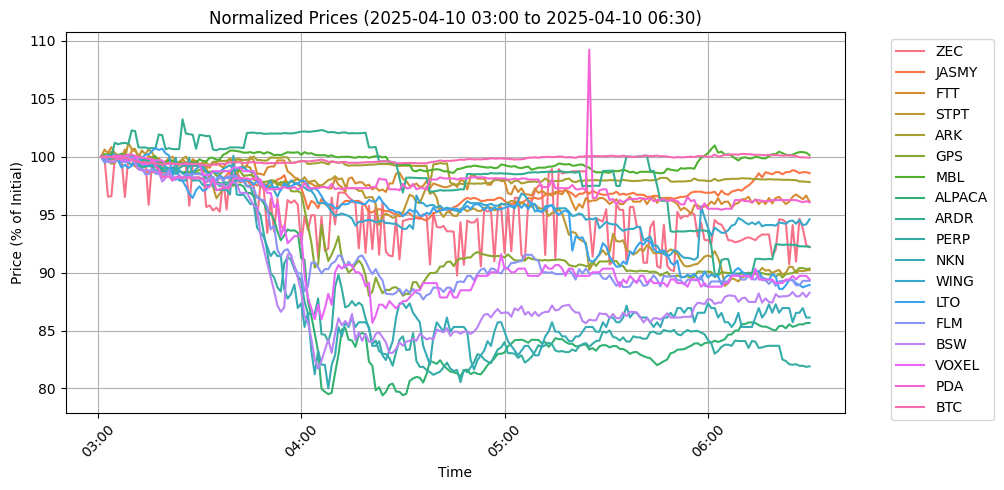

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter, HourLocator

# Only 7 days available
# Editable inputs
COINS = [ "ZEC", "JASMY", "FTT", "STPT", "ARK", "GPS", "MBL", "ALPACA", "ARDR", "PERP", "NKN", "WING", "LTO", "FLM", "BSW", "VOXEL", "PDA", "BTC"]  # Token tickers
START_DATETIME = "2025-04-10 03:00:00"             # Beginning datetime
END_DATETIME = "2025-04-10 06:30:00"               # Ending datetime
INTERVAL_MINUTES = 1                               # Data interval in minutes
API_KEY = "YOUR_CRYPTOCOMPARE_API_KEY"             # From https://www.cryptocompare.com/

# Convert datetimes and calculate period
start_dt = pd.to_datetime(START_DATETIME)
end_dt = pd.to_datetime(END_DATETIME)
period_minutes = int((end_dt - start_dt).total_seconds() / 60)
end_timestamp = int(end_dt.timestamp())

# Fetch minute data
url = "https://min-api.cryptocompare.com/data/v2/histominute"
data_dict = {}
for coin in COINS:
    params = {
        "fsym": coin,
        "tsym": "USD",
        "limit": period_minutes - 1,
        "toTs": end_timestamp,
        "aggregate": INTERVAL_MINUTES,
        "api_key": API_KEY
    }
    try:
        response = requests.get(url, params=params).json()
        if response.get("Response") == "Success" and response.get("Data", {}).get("Data"):
            times = [pd.Timestamp.fromtimestamp(e["time"]) for e in response["Data"]["Data"]]
            prices = [e["close"] for e in response["Data"]["Data"] if e["close"] > 0]
            if prices:
                data_dict[coin] = pd.Series(prices, index=times)
    except:
        print(f"Failed to fetch {coin}")
        continue

# Create and clean DataFrame
df = pd.DataFrame(data_dict).dropna()
if df.empty:
    print("No valid data retrieved.")
    exit()

# Calculate percentage change for each token
pct_change = ((df.iloc[-1] - df.iloc[0]) / df.iloc[0] * 100).round(2)

# Preview: Show percentage change table
print("\nPercentage Change (End vs. Beginning Price):")
pct_df = pd.DataFrame({
    "Token": pct_change.index,
    "Change (%)": pct_change.values
})
print(pct_df.to_string(index=False))

# Normalize prices
normalized = df / df.iloc[0] * 100

# Save to Excel
df.to_excel(f"{COINS[0].lower()}_et_al_usd.xlsx")
print(f"\nData saved to '{COINS[0].lower()}_et_al_usd.xlsx'")

# Plot normalized prices
fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette("husl", len(df.columns))
for coin, color in zip(df.columns, colors):
    ax.plot(df.index, normalized[coin], color=color, label=coin)
ax.set_ylabel("Price (% of Initial)")
ax.set_title(f"Normalized Prices ({start_dt.strftime('%Y-%m-%d %H:%M')} to {end_dt.strftime('%Y-%m-%d %H:%M')})")
ax.grid(True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.xaxis.set_major_locator(HourLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax.set_xlabel("Time")
plt.xticks(rotation=45)
plt.tight_layout()
fig.subplots_adjust(right=0.85)
plt.show()